Based on: [Neural Style Transfer: Creating Art with Deep Learning using tf.keras and eager execution][medium]

Original [Github repository][github], licensed under [Apache License 2.0][license]

[medium]: https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398
[github]: https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
[license]: https://apache.org/licenses/LICENSE-2.0

In [1]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

from IPython.display import display, Markdown

In [2]:
tf.enable_eager_execution()

In [3]:
def load_image(url):
    max_dim = 512
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image.thumbnail((max_dim, max_dim))
    return image.copy()

def process_image(image):
    image = kp_image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return tf.keras.applications.vgg19.preprocess_input(image)

def deprocess_image(processed_image):
    image = processed_image.copy()
    if len(image.shape) == 4:
        image = np.squeeze(image, 0)
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    image = image[:, :, ::-1]
    return np.clip(image, 0, 255).astype('uint8')

In [4]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [5]:
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    model = models.Model(vgg.input, model_outputs)
    for layer in model.layers:
        layer.trainable = False
    return model

In [6]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [7]:
def get_feature_representations(model, content_image, style_image):
    content_image = process_image(content_image)
    style_image = process_image(style_image)
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features

In [8]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    style_score = 0
    content_score = 0
    weight_per_style_layer = 1.0 / float(num_style_layers)
    
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
        
    weight_per_content_layer = 1.0 / float(num_content_layers)
    
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
        
    style_score *= style_weight
    content_score *= content_weight
    loss = style_score + content_score
    return loss, style_score, content_score

In [9]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [10]:
def run_style_transfer(content_image, style_image, num_iterations, content_weight, style_weight): 
    model = get_model()
        
    style_features, content_features = get_feature_representations(model, content_image, style_image)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    init_image = process_image(content_image)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    iter_count = 1
    best_loss, best_image = float('inf'), None
    loss_weights = (style_weight, content_weight)
    
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        if loss < best_loss:
            best_loss = loss
            best_image = deprocess_image(init_image.numpy())
            
    return best_image, best_loss 

content image torun


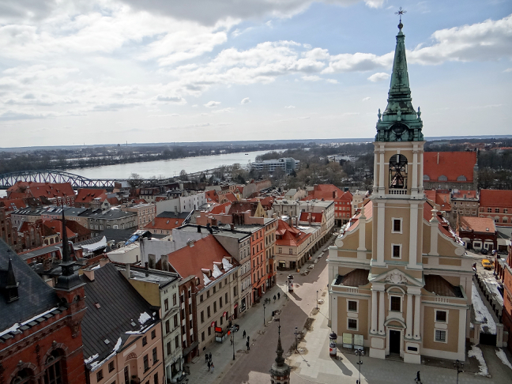

content image zubr


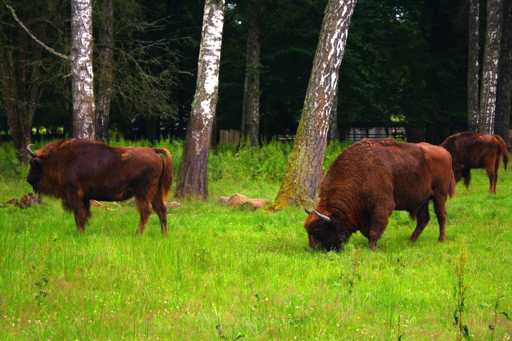

style image witkacy


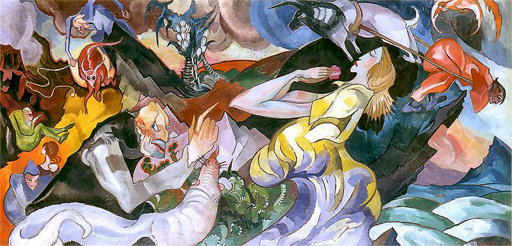

style image vangogh


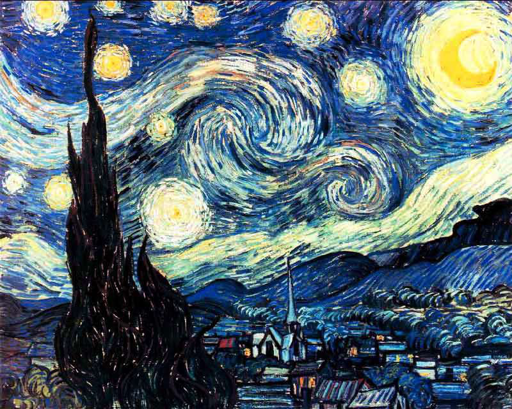

style image matejko


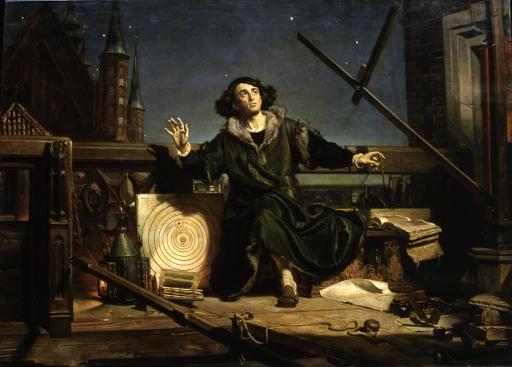

In [11]:
content_images = {
    'torun': 'https://upload.wikimedia.org/wikipedia/commons/c/cd/Toru%C5%84%2C_Ko%C5%9Bci%C3%B3%C5%82_%C5%9Aw._Ducha.jpg',
    'zubr': 'https://upload.wikimedia.org/wikipedia/commons/2/29/Bia%C5%82owieski_Park_Narodowy03_23a.jpg'
}

style_images = {
    'witkacy': 'https://upload.wikimedia.org/wikipedia/commons/2/2e/Witkacy_Kuszenie_sw_A_2.jpg',
    'vangogh': 'https://upload.wikimedia.org/wikipedia/commons/f/f2/VangoghStarry-night2.jpg',
    'matejko': 'https://upload.wikimedia.org/wikipedia/commons/8/88/Jan_Matejko-Astronomer_Copernicus-Conversation_with_God.jpg'
}

for name, address in content_images.items():
    content_images[name] = load_image(address)
    print(f'content image {name}')
    display(content_images[name])

for name, address in style_images.items():
    style_images[name] = load_image(address)
    print(f'style image {name}')
    display(style_images[name])

In [12]:
from os.path import isfile
from time import time
from datetime import timedelta

style_exponents = [-2, -4, -6]

num_iterations = 1000

for content_image_name, content_image in content_images.items():
    for style_image_name, style_image in style_images.items():
        for e in style_exponents:
            path = f'results/{content_image_name}_{style_image_name}_1e{e}.jpg'
            if isfile(path):
                continue
            style_weight = 10 ** e
            start = time()
            best_image, best_loss = run_style_transfer(
                content_image,
                style_image,
                content_weight=1,
                style_weight=style_weight,
                num_iterations=num_iterations
            )
            end = time()
            delta = timedelta(seconds=(end - start))
            print(f'{path} done in {str(delta)}')
            best_image = Image.fromarray(best_image)
            best_image.save(path)

results/torun_witkacy_1e-2.jpg done in 0:03:12.214248
results/torun_witkacy_1e-4.jpg done in 0:03:25.609643
results/torun_witkacy_1e-6.jpg done in 0:03:08.765309
results/torun_vangogh_1e-2.jpg done in 0:03:15.946834
results/torun_vangogh_1e-4.jpg done in 0:03:27.144745
results/torun_vangogh_1e-6.jpg done in 0:05:13.694714
results/torun_matejko_1e-2.jpg done in 0:07:24.675189
results/torun_matejko_1e-4.jpg done in 0:08:59.048739
results/torun_matejko_1e-6.jpg done in 0:16:42.189986
results/zubr_witkacy_1e-2.jpg done in 0:08:36.917587
results/zubr_witkacy_1e-4.jpg done in 0:20:17.239546
results/zubr_witkacy_1e-6.jpg done in 0:17:04.839859
results/zubr_vangogh_1e-2.jpg done in 0:14:05.914612
results/zubr_vangogh_1e-4.jpg done in 0:13:50.411059
results/zubr_vangogh_1e-6.jpg done in 0:15:05.582458
results/zubr_matejko_1e-2.jpg done in 0:22:50.917651
results/zubr_matejko_1e-4.jpg done in 0:16:22.502264
results/zubr_matejko_1e-6.jpg done in 0:19:41.822496


In [13]:
for content_image_name, content_image in content_images.items():
    for style_image_name, style_image in style_images.items():
        for e in style_exponents:
            print(f'content: {content_image_name} with weight 1')
            print(f'style: {style_image_name} with weight 1e{e}')
            path = f'results/{content_image_name}_{style_image_name}_1e{e}.jpg'
            display(Markdown(f'![]({path})'))

content: torun with weight 1
style: witkacy with weight 1e-2


![](results/torun_witkacy_1e-2.jpg)

content: torun with weight 1
style: witkacy with weight 1e-4


![](results/torun_witkacy_1e-4.jpg)

content: torun with weight 1
style: witkacy with weight 1e-6


![](results/torun_witkacy_1e-6.jpg)

content: torun with weight 1
style: vangogh with weight 1e-2


![](results/torun_vangogh_1e-2.jpg)

content: torun with weight 1
style: vangogh with weight 1e-4


![](results/torun_vangogh_1e-4.jpg)

content: torun with weight 1
style: vangogh with weight 1e-6


![](results/torun_vangogh_1e-6.jpg)

content: torun with weight 1
style: matejko with weight 1e-2


![](results/torun_matejko_1e-2.jpg)

content: torun with weight 1
style: matejko with weight 1e-4


![](results/torun_matejko_1e-4.jpg)

content: torun with weight 1
style: matejko with weight 1e-6


![](results/torun_matejko_1e-6.jpg)

content: zubr with weight 1
style: witkacy with weight 1e-2


![](results/zubr_witkacy_1e-2.jpg)

content: zubr with weight 1
style: witkacy with weight 1e-4


![](results/zubr_witkacy_1e-4.jpg)

content: zubr with weight 1
style: witkacy with weight 1e-6


![](results/zubr_witkacy_1e-6.jpg)

content: zubr with weight 1
style: vangogh with weight 1e-2


![](results/zubr_vangogh_1e-2.jpg)

content: zubr with weight 1
style: vangogh with weight 1e-4


![](results/zubr_vangogh_1e-4.jpg)

content: zubr with weight 1
style: vangogh with weight 1e-6


![](results/zubr_vangogh_1e-6.jpg)

content: zubr with weight 1
style: matejko with weight 1e-2


![](results/zubr_matejko_1e-2.jpg)

content: zubr with weight 1
style: matejko with weight 1e-4


![](results/zubr_matejko_1e-4.jpg)

content: zubr with weight 1
style: matejko with weight 1e-6


![](results/zubr_matejko_1e-6.jpg)